# Looking at how we can fit discrete models with variational inference 

This code mainly looks at simpler problem of finding a discrete Q which approximates a fixed, known discrete P by minimizing KL divergence.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from multiple_subject_vae_2 import BernoulliCondDistribution
from multiple_subject_vae_2 import CondSpikeSlabDistribution
from multiple_subject_vae_2 import CondGaussianDistribution
from multiple_subject_vae_2 import ConstantRealFcn
from multiple_subject_vae_2 import ConstantLowerBoundedFcn
from multiple_subject_vae_2 import ConstantLowerUpperBoundedFcn
from multiple_subject_vae_2 import LogBumpFcn
from multiple_subject_vae_2 import make_bernoulli_vi_debug_figure
from multiple_subject_vae_2 import visualize_bernoulli_distribution
from multiple_subject_vae_2 import visualize_spike_slab_distribution

## Generate neuron properties for all of the simulations below

In [3]:
# Properties of neurons we condition on 
neuron_props = torch.zeros(2000, 2).uniform_()

## Here we find a q distribution which approximates a fixed p by minimizing kl divergencve

In [21]:
# Basic Bernoulli distributions
#p = BernoulliCondDistribution(ConstantLowerUpperBoundedFcn(1, lower_bound=-10.0, upper_bound=0.0))
#q = BernoulliCondDistribution(ConstantLowerUpperBoundedFcn(1, lower_bound=-10.0, upper_bound=0.0))
#p.log_prob_fcn.v.data = torch.tensor([2.0])

# Bernoulli distributions which change probabilities condition on neuron properties
p_log_prob_fcn = LogBumpFcn(2)
p_log_prob_fcn.log_gain_vl.v.data = torch.tensor([1000.0])
p_log_prob_fcn.ctr.data = torch.tensor([.25, .25])
p_log_prob_fcn.ctr_stds.v.data = torch.tensor([-2.0, -2])
p = BernoulliCondDistribution(p_log_prob_fcn)

q_log_prob_fcn = LogBumpFcn(2)
q_log_prob_fcn.ctr_stds.v.data = torch.tensor([-1, -1.0])
#q_log_prob_fcn.log_gain_vl.lower_bound = np.log(.02)
#q_log_prob_fcn.log_gain_vl.v.data = torch.tensor(1.0)
q = BernoulliCondDistribution(q_log_prob_fcn)

it: 0, o: -5677.236
it: 50, o: 136.1742
it: 100, o: 202.58952
it: 150, o: 117.36514
it: 200, o: 105.49105
it: 250, o: 93.25463
it: 300, o: 107.10371
it: 350, o: -19.453497
it: 400, o: -81.58391
it: 450, o: -113.66652


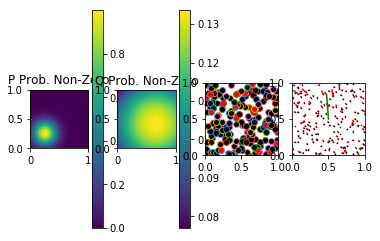

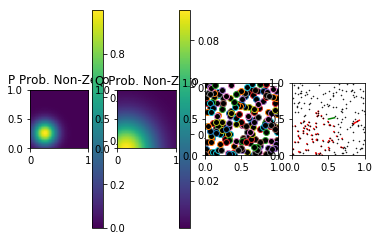

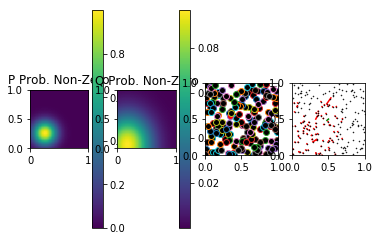

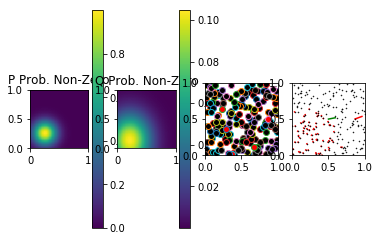

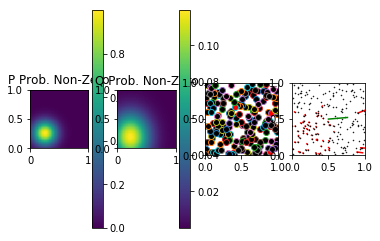

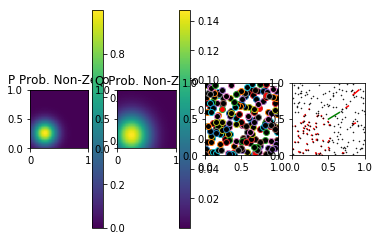

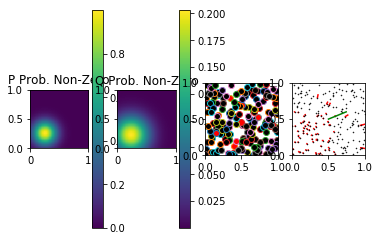

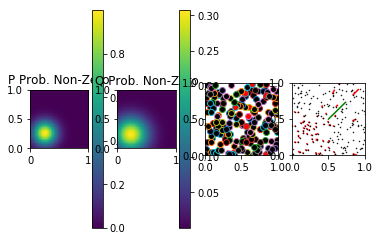

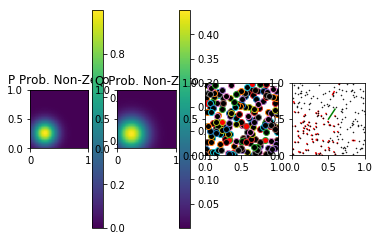

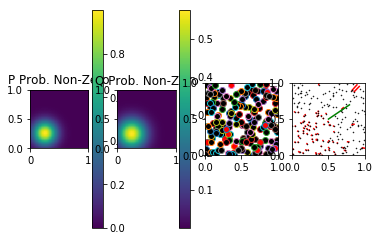

In [22]:
## Fit q to p with variational inference

params = q.parameters()
optim = torch.optim.Adam(params=params, lr=.01)

n_its = 500
batch_size = 5000
o_vls = np.zeros(n_its)
sum_l = np.zeros(n_its)
l_log = [None]*n_its
ctr_grad_log_mag = np.zeros(n_its)
ctr_stds_grad_log_mag = np.zeros(n_its)
cur_stds_log_mag = np.zeros(n_its)

c_i = torch.zeros(1)
for i in range(n_its):
    optim.zero_grad()
    
    with torch.no_grad():
        smp_inds = np.random.choice(neuron_props.shape[0], batch_size)
        smp_i = q.sample(neuron_props[smp_inds,:])
        l = q.log_prob(neuron_props[smp_inds,:], smp_i) - p.log_prob(neuron_props[smp_inds,:], smp_i)
        sum_l[i] = torch.sum(l).numpy()
        #c_i = torch.mean(l)
        l_log[i] = l.detach().numpy()
    
    o = torch.sum((l- c_i)*q.log_prob(neuron_props[smp_inds,:], smp_i))
    
    o.backward()
    
    with torch.no_grad():
        ctr_grad_log_mag[i] = torch.sqrt(torch.sum(q_log_prob_fcn.ctr.grad**2))
        ctr_stds_grad_log_mag[i] = torch.sqrt(torch.sum(q_log_prob_fcn.ctr_stds.v.grad**2))
        cur_stds_log_mag[i] = torch.sqrt(torch.sum(q_log_prob_fcn.ctr_stds.v.data**2))
        
    optim.step();
    
    record_o = o.detach().numpy()
    if i % 50 == 0:
        print('it: ' + str(i) + ', o: ' + str(record_o))
        j_range = np.arange(0, neuron_props.shape[0], 10)
        l_d = l.detach().numpy()
        smp_i_plot = smp_i.detach().numpy()
        
        grads = np.zeros([len(j_range), 2])
        for j_i, j in enumerate(j_range):
            optim.zero_grad()
            with torch.no_grad():
                l_j = (q.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].unsqueeze(0)) - 
                        p.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].unsqueeze(0)))
            
            o_j = l_j*q.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].reshape([1]))
            o_j.backward()
            grads[j_i,:] = q.log_prob_fcn.ctr.grad.data.numpy().copy()
        
        make_bernoulli_vi_debug_figure(q, p, smp_x=neuron_props[j_range], smp_y=smp_i_plot[j_range],
                                       grads=grads)

    o_vls[i] = record_o
    

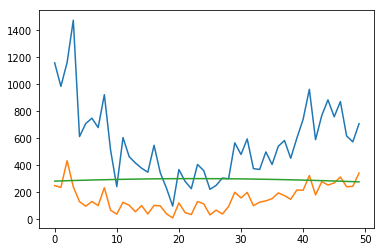

In [6]:
plt.figure()
plt.plot(ctr_grad_log_mag)
plt.plot(ctr_stds_grad_log_mag)
plt.plot(cur_stds_log_mag*100)

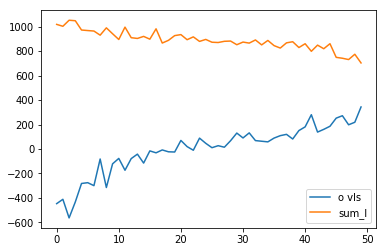

In [7]:
## Look at plot of o values
plt.plot(o_vls)
plt.plot(sum_l)
plt.legend(['o vls', 'sum_l'])

## Look at true and estimated distributions 

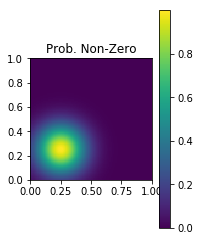

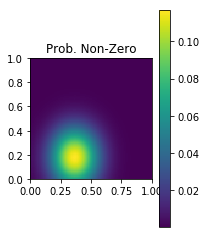

In [8]:
visualize_bernoulli_distribution(p)
visualize_bernoulli_distribution(q)

## Generate data from one spike and slab distribution and fit another with maximum likelihood

We use the same ground truth data and distribution we used with the variational inference approach

In [9]:
# Ground truth distribution 
spike_log_prob_fcn = LogBumpFcn(2)
spike_log_prob_fcn.ctr_stds.v.data = torch.tensor([-2.0, -2.0])
spike_dist = BernoulliCondDistribution(log_prob_fcn=spike_log_prob_fcn)



slab_mn_fcn = ConstantRealFcn(n_dims=1)
slab_mn_fcn.vl.data = torch.tensor([5.0])
slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
slab_std_fcn.log_vl.data = torch.tensor([0.0])
slab_dist = CondGaussianDistribution(slab_mn_fcn, slab_std_fcn)

spike_slab_dist = CondSpikeSlabDistribution(spike_dist=spike_dist, slab_dist=slab_dist, d=1)

In [10]:
# Get samples for true distribution
with torch.no_grad():
    support, nz_vls = spike_slab_dist.sample(neuron_props)

    y = torch.zeros(len(support))
    y[support] = nz_vls
    y = y.unsqueeze(1)

In [11]:
# Fitted distribution 

f_spike_log_prob_fcn = LogBumpFcn(2)
f_spike_dist = BernoulliCondDistribution(f_spike_log_prob_fcn)

f_slab_mn_fcn = ConstantRealFcn(n_dims=1)
f_slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
f_slab_std_fcn.log_vl.data = torch.tensor([5.0])
f_slab_dist = CondGaussianDistribution(f_slab_mn_fcn, f_slab_std_fcn)

f_spike_slab_dist = CondSpikeSlabDistribution(spike_dist=f_spike_dist, slab_dist=f_slab_dist,
                                              d=1)


In [12]:
## Fit spike slab distribution with maximum likelihood

params = f_spike_slab_dist.parameters()
optim = torch.optim.Adam(params=params, lr=.01)

for i in range(2000): 
    optim.zero_grad()
    
    nll = -1*torch.sum(f_spike_slab_dist.log_prob(neuron_props, y))
    nll.backward()
    optim.step()
    if i % 200 == 0:
        print('i:' + str(i) + ', nll: ' +  str(nll.detach()))

i:0, nll: tensor(455.1981)
i:200, nll: tensor(276.5945)
i:400, nll: tensor(217.9567)
i:600, nll: tensor(198.6658)
i:800, nll: tensor(196.3963)
i:1000, nll: tensor(191.2954)
i:1200, nll: tensor(164.2237)
i:1400, nll: tensor(160.3885)
i:1600, nll: tensor(160.2347)
i:1800, nll: tensor(160.2347)


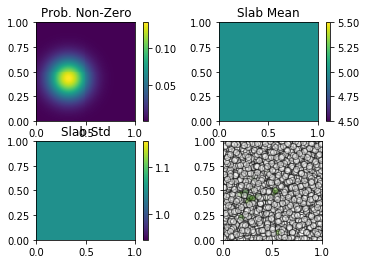

In [13]:
# Visualize True distribution
visualize_spike_slab_distribution(spike_slab_dist, smp_x=neuron_props, smp_y=y.squeeze())

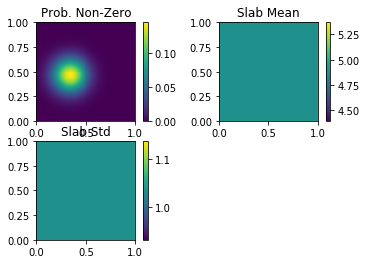

In [14]:
# Visualize Fit distribution
visualize_spike_slab_distribution(f_spike_slab_dist)